In [1322]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from data.encoder import Encoder
import missingno as msno
from pytz import country_names
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from analyzer.stat_criterion.stat_criteria import StatCriteria
from analyzer.metric import MetricCalculator
from data.io import Reader, Saver
from data.plot import Drawer
import seaborn as sns
from analyzer.stat_criterion.analyser_timeseries_custom import AnalyserTimeSeriesCustom
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from statsmodels.tsa.api import VARMAX

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Постановка задачи

Коэффициент Джини (индекс Джини, или «индекс справедливости») — показатель, отражающий степень неравенства в распределении доходов внутри различных групп населения. Коэффициент в 1912 году разработал итальянский статистик Коррадо Джини. Показатель принимает значения от 0 (в случае абсолютного равенства) до 1 (в случае абсолютного неравенства).

1. Предскажите коэффициент Джини для России на 2021
2. Найдите страну на постсоветском пространстве у которой коэф.Джини наименьший
3. Определите для каждого десятилетия средний уровень коэф.Джини для всех стран и постройте столбчатую диаграмму
4. Добавить столбец регион (подумайте как это сделать проще всего)
5. Определите изменение коэффицинта Джини по регионам
6. Найдите страну с наименьшим коэф.Джини на протяжении всей истории наблюдений (есть ли такая вообще)

датасет: https://raw.githubusercontent.com/Semendyeav/datasets/main/PDA210_Test_4.csv

# Выгрузка и проверка целостности датасета

In [1323]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv("https://raw.githubusercontent.com/Semendyeav/datasets/main/PDA210_Test_4.csv")
Saver.save_csv(df_original, "PDA210_Control_Test_4", False)
df = df_original.copy().reset_index(drop=True)
df['value'] = df['value'] / 100
df.head(10)

Файл успешно сохранён: ./dataset/PDA210_Control_Test_4.csv


,country_code,country_name,year,value
0,COL,Colombia,2013,0.526
1,SVN,Slovenia,2010,0.249
2,POL,Poland,1989,0.269
3,MDG,Madagascar,1999,0.386
4,SVN,Slovenia,2007,0.244
5,HUN,Hungary,1991,0.296
6,NLD,Netherlands,2012,0.276
7,MNG,Mongolia,2010,0.331
8,HND,Honduras,2006,0.575
9,PRY,Paraguay,2018,0.460


In [1324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896 entries, 0 to 1895
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  1896 non-null   object 
 1   country_name  1896 non-null   object 
 2   year          1896 non-null   int64  
 3   value         1896 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 59.4+ KB


## пропуски в данных

In [1325]:
# посмотрим на пропуски в данных
df.isna().sum()

country_code    0
country_name    0
year            0
value           0
dtype: int64

<Axes: >

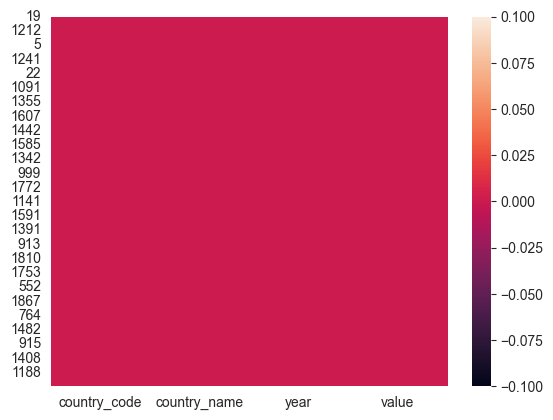

In [1326]:
# Посмотрим на пропуски
sns.heatmap(df.sort_values(by='year').isna())

<Axes: >

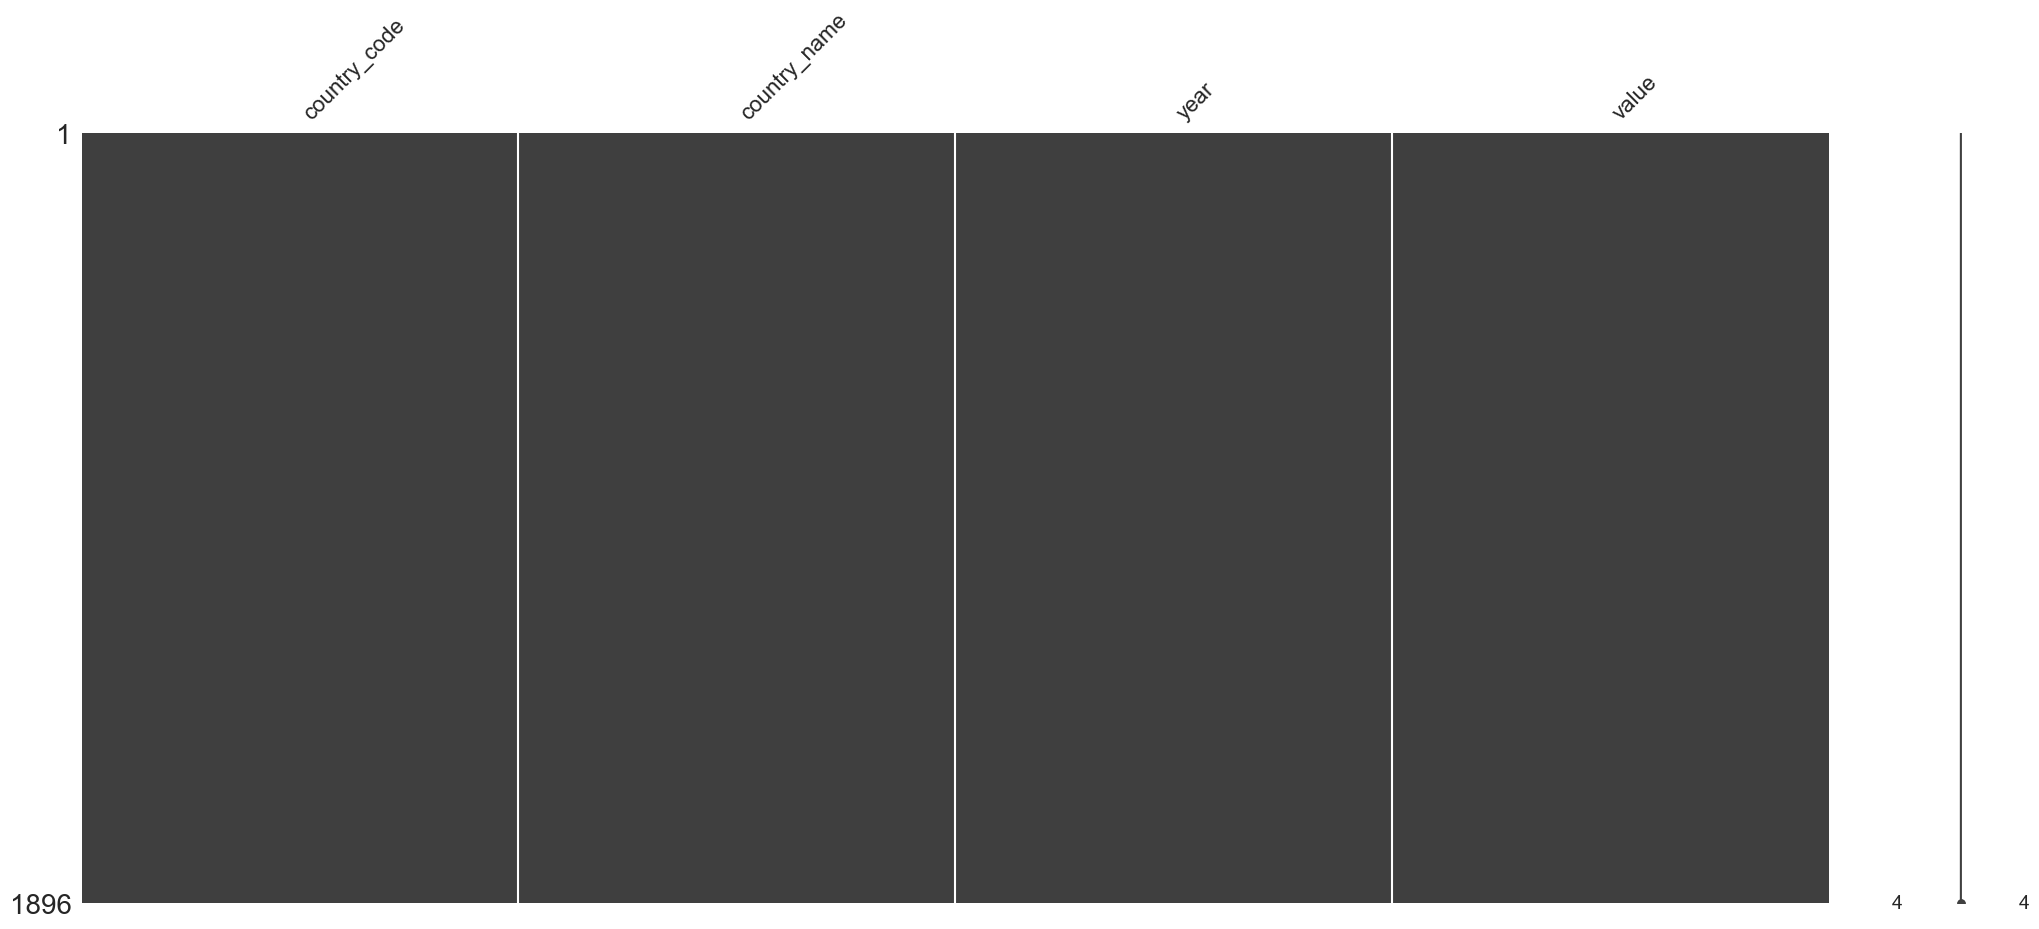

In [1327]:
# Посмотрим на пропуски
msno.matrix(df)

## выявление неестественных значений

In [1328]:
# Посмотрим статистику о датасете
df.describe()

,year,value
count,1896.000000,1896.000000
mean,2006.275844,0.381793
std,9.348789,0.090776
min,1967.000000,0.202000
25%,2000.750000,0.312000
50%,2008.000000,0.361000
75%,2014.000000,0.441000
max,2021.000000,0.658000


# Ответы на вопросы

## предскажите коэффициент Джини для России на 2021

In [1329]:
mask = df['country_name'] == 'Russian Federation'

df_RF = df[mask].sort_values(by='year', ascending=False)
df_RF.head(10)

,country_code,country_name,year,value
411,RUS,Russian Federation,2020,0.360
731,RUS,Russian Federation,2019,0.377
571,RUS,Russian Federation,2018,0.375
740,RUS,Russian Federation,2017,0.372
671,RUS,Russian Federation,2016,0.368
1503,RUS,Russian Federation,2015,0.377
1883,RUS,Russian Federation,2014,0.399
1155,RUS,Russian Federation,2013,0.409
909,RUS,Russian Federation,2012,0.407
318,RUS,Russian Federation,2011,0.397


Прогноз на следующий год: 0.3548


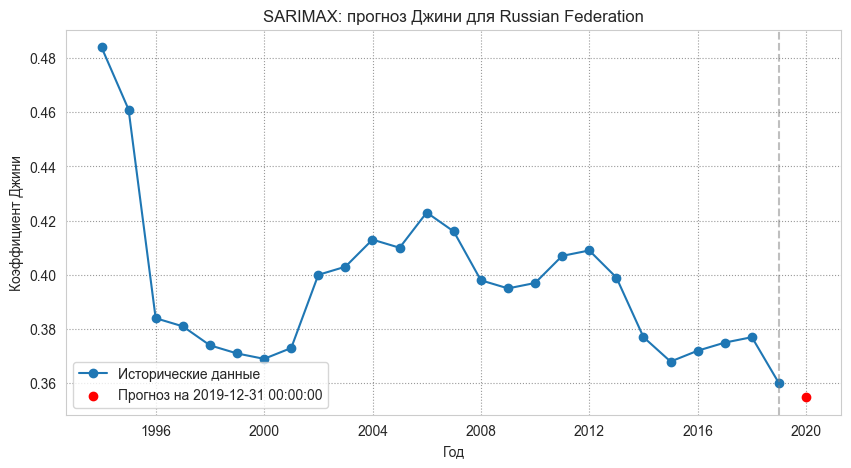

In [1330]:
df_RF.drop(columns=['country_code', 'country_name'], axis=1, inplace=True)

df_RF.sort_values('year', inplace=True)
df_RF['year'] = pd.to_datetime(df_RF['year'], format="%Y")
df_RF.set_index('year', inplace=True)
series = df_RF['value']
series.index = pd.date_range(start=series.index.min(), periods=len(series), freq='YE')

model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
results = model.fit(disp=False)

# Прогноз на 1 год вперёд
forecast = results.get_forecast(steps=1)
predicted_value = forecast.predicted_mean.iloc[0]
conf_int = forecast.conf_int()

print(f"Прогноз на следующий год: {predicted_value:.4f}")

x_forecast = series.index[-1] + pd.DateOffset(years=1)

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(series, label="Исторические данные", marker='o')
plt.axvline(series.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.scatter(x_forecast, predicted_value, color='red', label=f"Прогноз на {x_forecast}")
plt.legend()
plt.title(f"SARIMAX: прогноз Джини для Russian Federation")
plt.xlabel("Год")
plt.ylabel("Коэффициент Джини")
plt.show()

## найдите страну на постсоветском пространстве у которой коэф.Джини наименьший

In [1331]:
# находим данные на последний год
gini_by_country = df.groupby('country_name')['value'].last().sort_values().reset_index()
gini_by_country.head(10)

,country_name,value
0,Slovak Republic,0.232
1,Slovenia,0.242
2,Norway,0.262
3,Sweden,0.264
4,Czechia,0.266
5,Kosovo,0.267
6,Azerbaijan,0.268
7,Iceland,0.268
8,Finland,0.273
9,Denmark,0.273


In [1332]:
post_soviet_countries = [
    "Russian Federation",
    "Ukraine",
    "Belarus",
    "Kazakhstan",
    "Armenia",
    "Georgia",
    "Azerbaijan",
    "Uzbekistan",
    "Kyrgyzstan",
    "Tajikistan",
    "Turkmenistan",
    "Moldova",
    "Lithuania",
    "Latvia",
    "Estonia",
]

mask = gini_by_country['country_name'].isin(post_soviet_countries)
gini_post_soviet = gini_by_country[mask].sort_values(by = 'value')

gini_post_soviet.head(10)

,country_name,value
6,Azerbaijan,0.268
12,Belarus,0.276
25,Tajikistan,0.308
29,Estonia,0.312
42,Uzbekistan,0.330
44,Armenia,0.330
53,Lithuania,0.348
56,Moldova,0.349
66,Latvia,0.356
89,Ukraine,0.393


## определите для каждого десятилетия средний уровень коэф.Джини для всех стран и постройте столбчатую диаграмму

In [1333]:
df['decade'] = (df['year'] // 10) * 10

In [1334]:
gini_decade_country = df.groupby(['country_name', 'decade'])['value'].mean().reset_index()

gini_decade_country.head(10)

,country_name,decade,value
0,Albania,1990,0.270000
1,Albania,2000,0.307667
2,Albania,2010,0.320143
3,Algeria,1980,0.402000
4,Algeria,1990,0.353000
5,Algeria,2010,0.276000
6,Angola,2000,0.473500
7,Angola,2010,0.513000
8,Argentina,1980,0.429667
9,Argentina,1990,0.479000


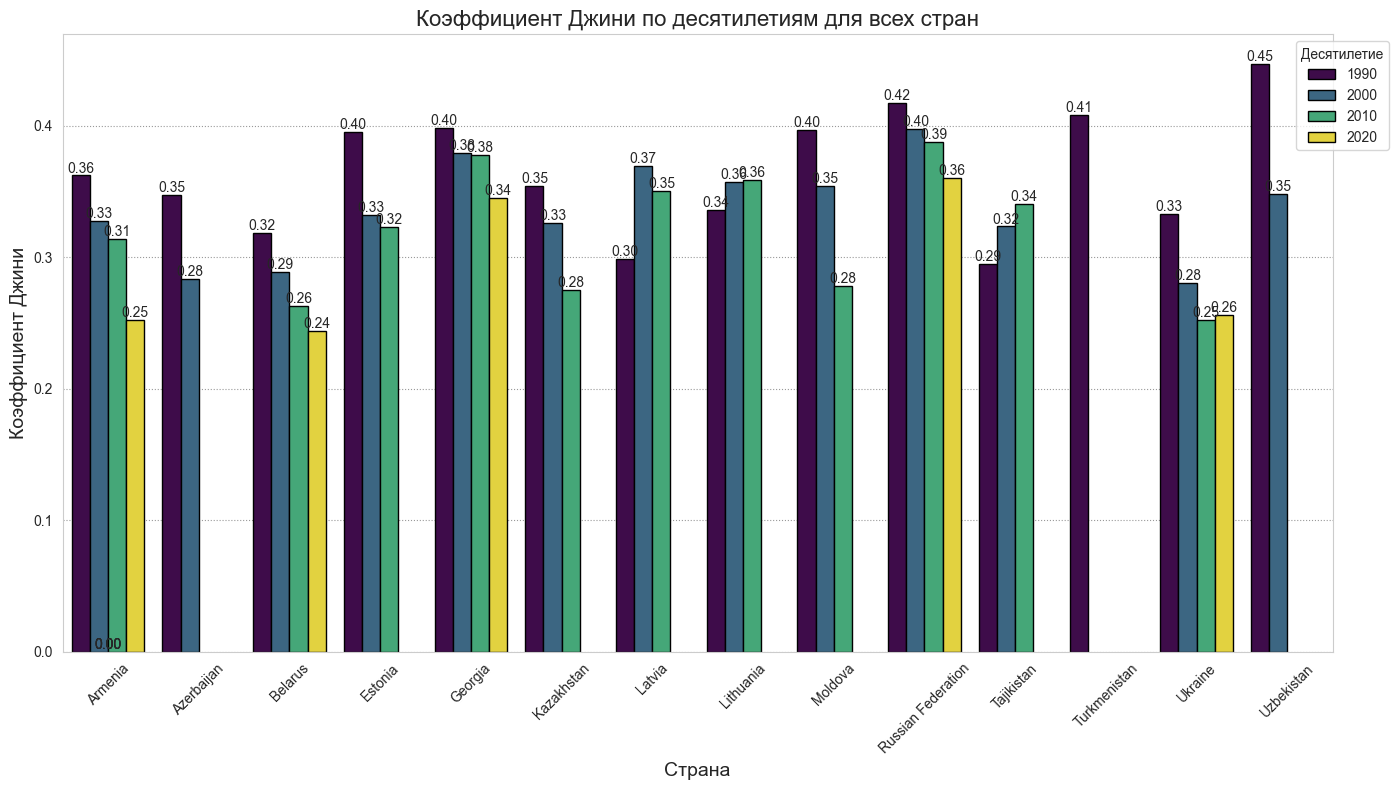

In [1335]:
plt.figure(figsize=(14, 8))

mask = gini_decade_country['country_name'].isin(post_soviet_countries)

sns.barplot(
    data=gini_decade_country[mask],
    x='country_name',
    y='value',
    hue='decade',
    palette='viridis',
    edgecolor='black'
)

plt.title('Коэффициент Джини по десятилетиям для всех стран', fontsize=16)
plt.xlabel('Страна', fontsize=14)
plt.ylabel('Коэффициент Джини', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Десятилетие', bbox_to_anchor=(1.05, 1))

# Добавляем подписи значений
for p in plt.gca().patches:
    plt.gca().annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 5), textcoords='offset points'
    )

plt.tight_layout()
plt.show()

## добавить столбец регион (подумайте как это сделать проще всего)

In [1336]:
# url = "https://restcountries.com/v3.1/all"
#
# try:
#     response = requests.get(url, timeout=10, verify=False)
#     response.raise_for_status()
#     data = response.json()
#
#     with open("countries.json", "w", encoding="utf-8") as f:
#         json.dump(data, f, ensure_ascii=False, indent=2)
#
# except requests.exceptions.RequestException as e:
#     print(f"Не удалось загрузить данные с API: {e}")

In [1337]:
with open('countries.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

country_region_mapping = {
    country.get('cca3', ''): country.get('region', 'Unknown')
    for country in data
}

def get_region(country_name):
    return country_region_mapping.get(country_name, "Unknown")

df['region'] = df['country_code'].apply(get_region)
df.head(10)

,country_code,country_name,year,value,decade,region
0,COL,Colombia,2013,0.526,2010,Americas
1,SVN,Slovenia,2010,0.249,2010,Europe
2,POL,Poland,1989,0.269,1980,Europe
3,MDG,Madagascar,1999,0.386,1990,Africa
4,SVN,Slovenia,2007,0.244,2000,Europe
5,HUN,Hungary,1991,0.296,1990,Europe
6,NLD,Netherlands,2012,0.276,2010,Europe
7,MNG,Mongolia,2010,0.331,2010,Asia
8,HND,Honduras,2006,0.575,2000,Americas
9,PRY,Paraguay,2018,0.460,2010,Americas


In [1338]:
mask = df['region'] == 'Unknown'
df[mask]['country_name'].unique()

array(['Kosovo'], dtype=object)

In [1339]:
mask = df['country_name'] == 'Kosovo'
df['region'] = df['region'].mask(mask, 'Europe')

In [1340]:
mask = df['region'] == 'Unknown'
df[mask]['country_name'].unique()

array([], dtype=object)

## определите изменение коэффицинта Джини по регионам

In [1341]:
gini_region = df.groupby(['region', 'year'])['value'].mean().reset_index()

gini_region.head(10)

,region,year,value
0,Africa,1980,0.468000
1,Africa,1984,0.392000
2,Africa,1985,0.454500
3,Africa,1986,0.470000
4,Africa,1987,0.399000
5,Africa,1988,0.377000
6,Africa,1989,0.444000
7,Africa,1990,0.371333
8,Africa,1991,0.470200
9,Africa,1992,0.448571


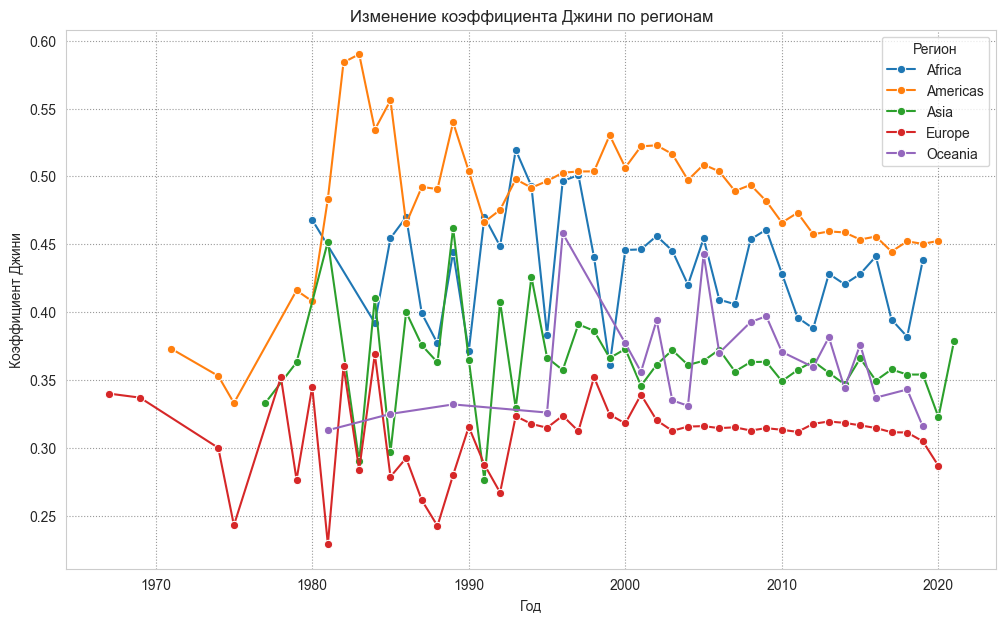

In [1342]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=gini_region, x='year', y='value', hue='region', marker='o')

plt.title('Изменение коэффициента Джини по регионам')
plt.xlabel('Год')
plt.ylabel('Коэффициент Джини')
plt.legend(title='Регион')
plt.grid(True)
plt.show()

## найдите страну с наименьшим коэф.Джини на протяжении всей истории наблюдений (есть ли такая вообще)

In [1343]:
df.sort_values(by='value', ascending=True)

,country_code,country_name,year,value,decade,region
548,SVK,Slovak Republic,1992,0.202,1990,Europe
1189,CZE,Czechia,1992,0.207,1990,Europe
361,HUN,Hungary,1987,0.210,1980,Europe
770,FIN,Finland,1987,0.222,1980,Europe
166,HRV,Croatia,1988,0.228,1980,Europe
...,...,...,...,...,...,...
576,BRA,Brazil,1989,0.633,1980,Americas
1391,ZAF,South Africa,2010,0.634,2010,Africa
863,BWA,Botswana,2002,0.647,2000,Africa
1515,ZAF,South Africa,2005,0.648,2000,Africa


# Первичный визуальный анализ зависимостей в данных

In [1344]:
df.drop(columns='country_name', axis=1, inplace=True)
df.drop(columns='decade', axis=1, inplace=True)

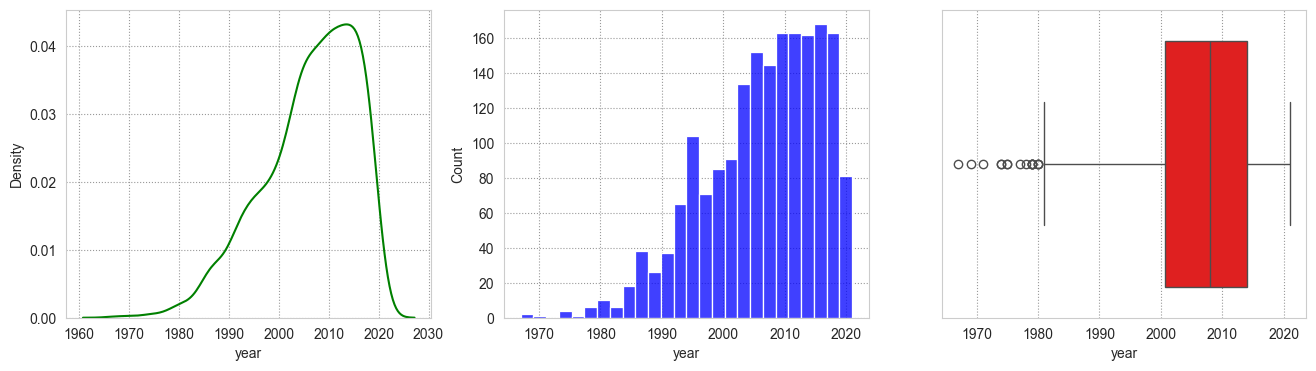

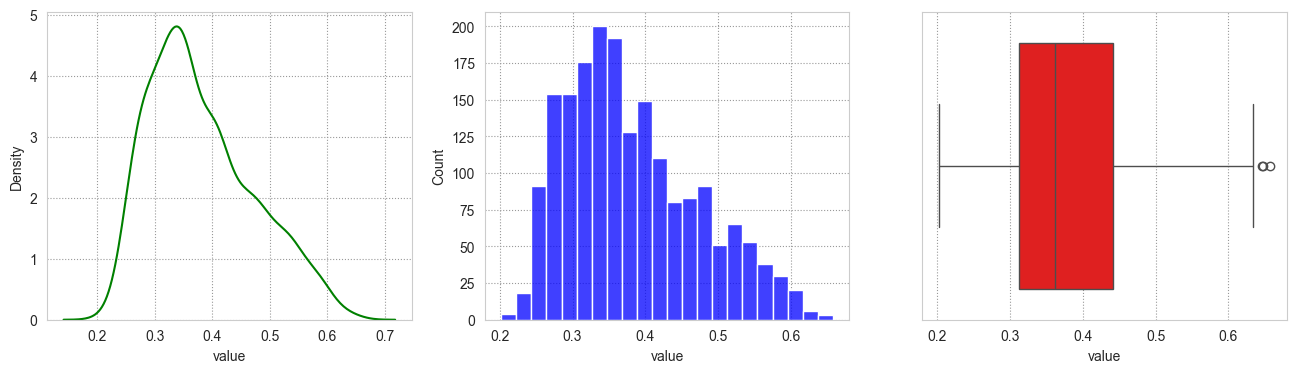

In [1345]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

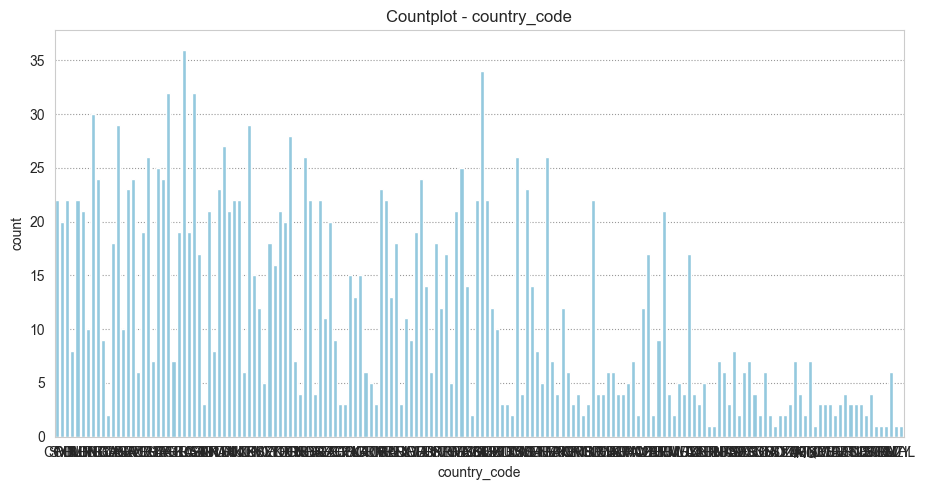

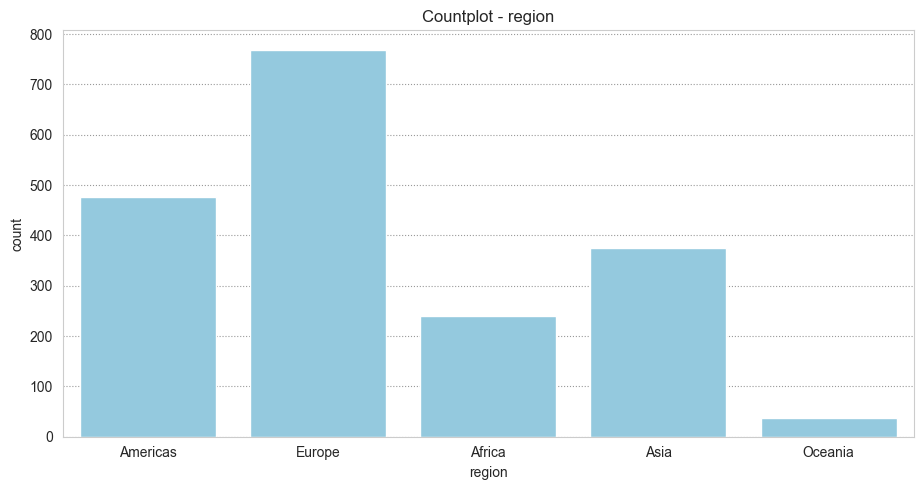

In [1346]:
# Посмотрим на распределение категориальных величин
Drawer.plot_categorical_seaborn(df)

# Анализ взаимосвязей в данных

## подготовка временного ряда

In [1347]:
df.index = pd.to_datetime(df['year'], format='%Y') 
df.sort_index(inplace=True)

target = ['value']

period = 5

## проверка на стационарность

In [1348]:
def test_stationarity(series):
    result = adfuller(series, autolag='AIC')
    print(f"p-value: {result[1]:.3f}")

    if result[1] < 0.05:
        print("Ряд стационарен.")
    else:
        print("Ряд нестационарен.")

test_stationarity(df[target])

p-value: 0.000
Ряд стационарен.


In [1349]:
def test_kpss(series):
    result = kpss(series, regression='ct', nlags="auto")
    print(f"p-value: {result[1]:.3f}")

    if result[1] < 0.05:
        print("Ряд не стационарен.")
    else:
        print("Ряд стационарен.")

test_kpss(df[target])

p-value: 0.010
Ряд не стационарен.


C:\Users\Tikhon\AppData\Local\Temp\ipykernel_10136\3876179710.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='ct', nlags="auto")


## декомпозиция

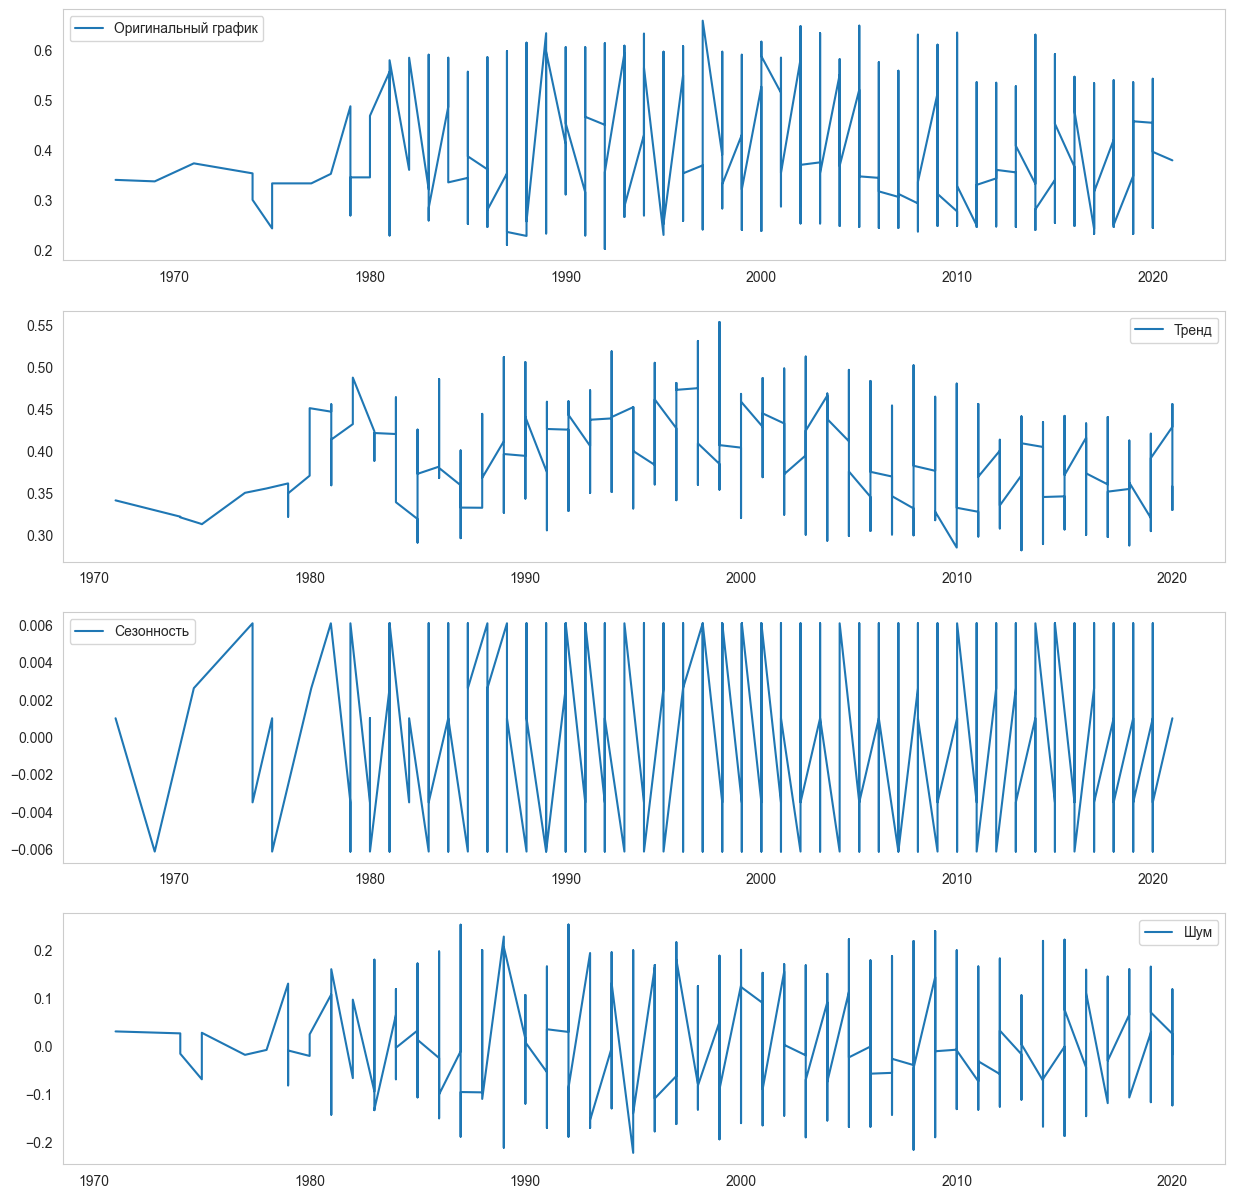

In [1350]:
analysis = AnalyserTimeSeriesCustom(df[target])
analysis.decompositon(model='add', period=period)

## автокорреляционное разложение

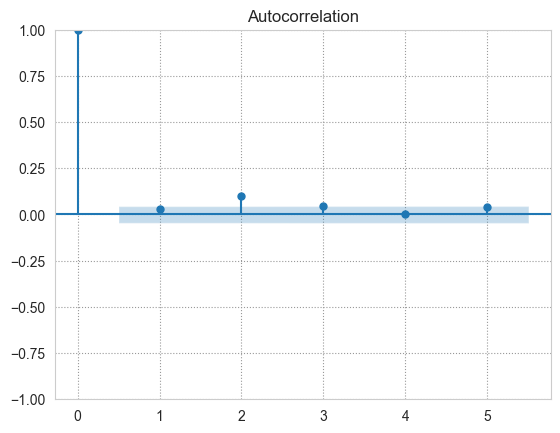

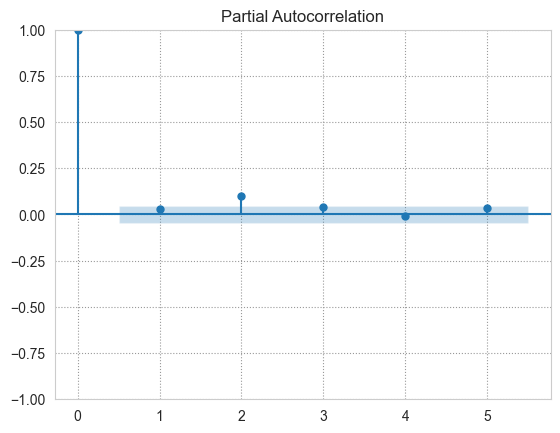

In [1351]:
analysis.auto_correlation(period)

## подготовка данных для обучения

In [1352]:
df['country_code'], _ = Encoder.labelEncoder(df['country_code'])
df['region'], _ = Encoder.labelEncoder(df['region'])

# df['country_code'] = df['country_code'].astype('float64')
# df['region'] = df['region'].astype('float64')

In [1353]:
separate_point = int(len(df) * 0.75)

y_train = df[target][:separate_point]
y_test = df[target][separate_point:]

X_train = df.drop(columns=target)[:separate_point]
X_test = df.drop(columns=target)[separate_point:]

## модель XGB

In [1354]:
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

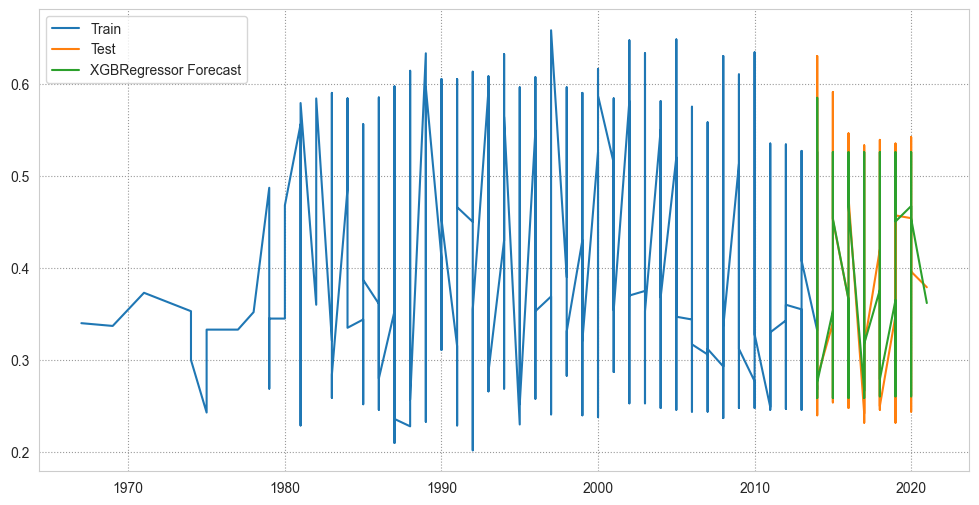

R²: 0.855
MAE: 0.02
MAPE: 0%
RMSE: 0
MSE: 0


In [1355]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='XGBRegressor Forecast')
plt.legend()
plt.show()

MetricCalculator.show_regression_metrics(y_test, y_pred)

## модель VARMAX

In [1356]:
train_data = df.iloc[:separate_point]
test_data = df.iloc[separate_point:]

endog_train = train_data[['value', 'country_code']]
exog_train = train_data[['region']]

endog_test = test_data[['value', 'country_code']]
exog_test = test_data[['region']]

model = VARMAX(endog=endog_train, exog=exog_train, order=(1, 1))
model_fitted = model.fit(disp=True)

forecast_interval = len(test_data)
forecast = model_fitted.forecast(steps=forecast_interval, exog=exog_test) 
print(forecast)

C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


         value  country_code
1422  0.322634     76.167597
1423  0.381004     76.211612
1424  0.328115     75.813645
1425  0.490153     79.099599
1426  0.440295     80.354673
...        ...           ...
1891  0.384387     78.077160
1892  0.382808     77.197038
1893  0.382721     77.200972
1894  0.437226     78.590444
1895  0.384297     78.079497

[474 rows x 2 columns]


C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning:

In [1357]:
print(model_fitted.summary())

                               Statespace Model Results                              
Dep. Variable:     ['value', 'country_code']   No. Observations:                 1422
Model:                           VARMAX(1,1)   Log Likelihood               -5778.272
                                 + intercept   AIC                          11586.543
Date:                       Sun, 06 Apr 2025   BIC                          11665.440
Time:                               12:19:09   HQIC                         11616.014
Sample:                                    0                                         
                                      - 1422                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):             0.01, 0.01   Jarque-Bera (JB):         10.47, 90.49
Prob(Q):                        0.93, 0.94   Prob(JB):                   0.01, 0.00
Heteroskedasticity (H):         0.58, 0.87   Skew:        

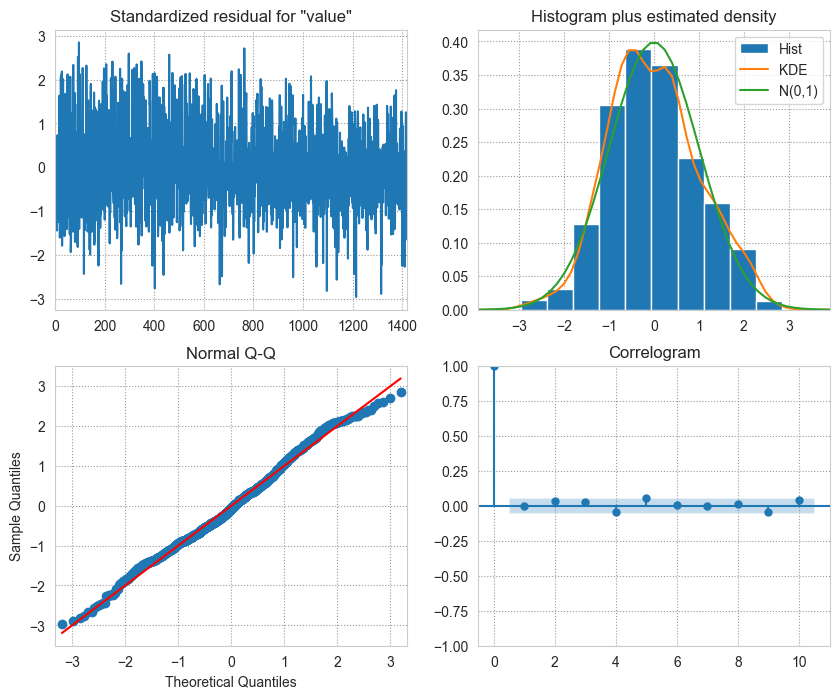

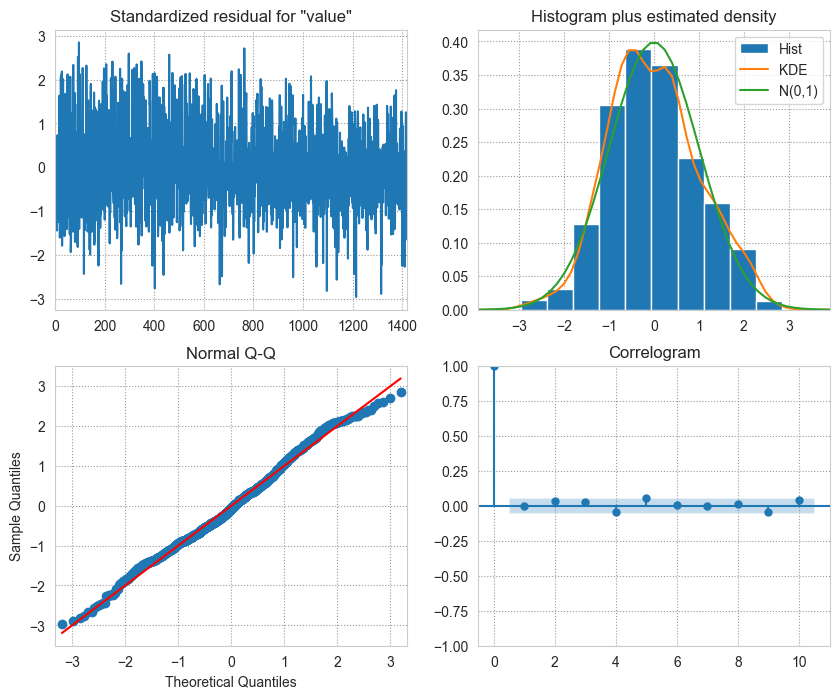

In [1358]:
model_fitted.plot_diagnostics(figsize=(10, 8))

In [1359]:
y_pred = forecast.iloc[:, 0].values
y_test = df['value'].iloc[-forecast_interval:]

MetricCalculator.show_regression_metrics(y_test, y_pred)

R²: 0.398
MAE: 0.05
MAPE: 0%
RMSE: 0
MSE: 0


## модель LSTM

In [1360]:
scaler = MinMaxScaler()

y = df[target]
X = df.drop(columns=target)

X_norm = scaler.fit_transform(X)

n_past = 30
test_separate_point = 8

# Нарезаем данные для обучения
X_train = []
y_train = []

for i in range(n_past, len(X_norm)-test_separate_point):
    X_train.append(X_norm[i-n_past:i, :]) 
    y_train.append(y.iloc[i])

X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1,1)

X_test = []
y_test = []

for i in range(len(X_norm)-test_separate_point, len(X_norm)):
    X_test.append(X_norm[i-n_past:i, :]) 
    y_test.append(y.iloc[i])

X_test = np.array(X_test)
y_test = np.array(y_test).reshape(-1,1)


In [1363]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(y_train.shape[1]))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

model.fit(X_train,y_train, epochs=20, batch_size=32, shuffle=False, validation_split=0.1)
y_pred = model.predict(X_test)


Epoch 1/20


C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1124 - root_mean_squared_error: 0.3194 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0794
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0156 - root_mean_squared_error: 0.1238 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0751
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 - root_mean_squared_error: 0.1189 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0744
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 - root_mean_squared_error: 0.1159 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0735
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128 - root_mean_squared_error: 0.1129 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0735
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0123 - root_mean_squared_error: 0.1104 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0123 - root_me

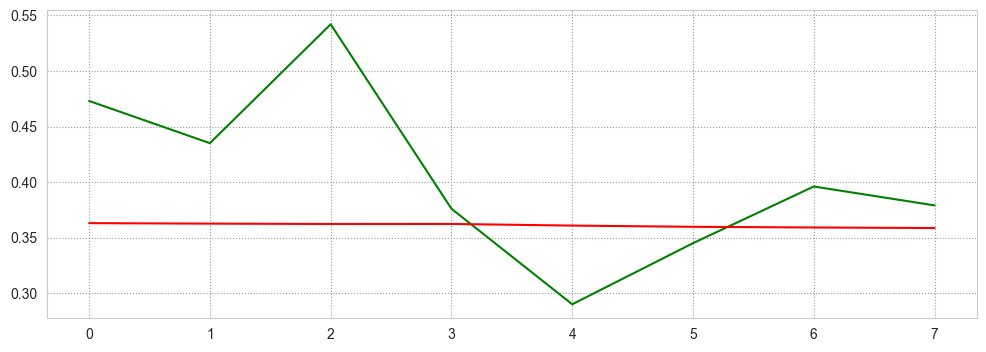

R²: -0.331
MAE: 0.06
MAPE: 0%
RMSE: 0
MSE: 0


In [1364]:
plt.figure(figsize=(12,4))
plt.plot(y_test, color='g')
plt.plot(y_pred, color='r')
plt.show()

MetricCalculator.show_regression_metrics(y_test, y_pred)